<a href="https://colab.research.google.com/github/latived/pibic-playground/blob/master/Polyp_Segmentation_with_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Esse notebook é adaptado de [Image Segmentation](https://colab.research.google.com/github/tensorflow/models/blob/master/samples/outreach/blogs/segmentation_blogpost/image_segmentation.ipynb#scrollTo=0GnwZ7CPaamI).

Aqui eu uso outro _dataset_: imagens de colonoscopia do meu projeto pesquisa. Tais imagens podem ser obtidas [aqui](http://mv.cvc.uab.es/projects/colon-qa/cvccolondb). 

Segmentação
--

Formalmente, segmentação de imagens refere-se ao processo de particionar uma imagem em um conjunto de pixels que desejamos identificar (nosso alvo) do _background_. Ao contrário do notebook original, que usa imagens de carros (ver [este link](https://www.kaggle.com/c/carvana-image-masking-challenge)), este meu usará de imagens biomédicas de colonoscopia. São duas coisas bem diferentes, portanto é de se esperar que os resultados não sejam os mesmos. De qualquer forma, isso só me ajuda a ir em busca das razões para tal, **aprendendo mais e fazendo mais**.

**Observação importante:** as imagens que utilizo ainda não foram pré-processadas. Não foram removidas as bordas pretas e os reflexos de luz, por exemplo. _Precisa?_

U-Net
--
O artigo original se encontra [aqui](https://arxiv.org/abs/1505.04597). É a primeira rede que faço, muito embora de um jeito guiado--apenas copiei o que pude do notebook original.

Essa rede tem o seguinte formato:
![Arquitetura U-Net](./u-net-architecture.png)

Legenda:
  - _conv 3x3, ReLU_ indica que o _kernel_ da convolução é uma matrix 3x3 e que a função de ativação da camada é a _Rectified Liner Units_.
  - _copy and crop_ indica que uma parte de uma camada foi copiada e concatenada a outra camada.
  - _max pool 2x2_ indica que, usando um _kernel_ 2x2, foi reduzida pela metade as dimensões da camada através da operação de _max pooling_, que nada mais é o valor máximo dentro da janela de extração.
  - _up-conv 2x2_ indica uma subida nas dimensões da camada, usando uma técnica de convolução com matrix 2x2.
  - _conv 1x1_ indica uma convolução com _kernel_ 1x1.
  

 Os conceitos acima ainda são me um tanto estranhos, apesar de já estar acostumado a lê-los por aí em tutoriais e afins. Por exemplo, qual sentido de uma convolução com _kernel_ 1x1? Pelo que li, tem a ver com redução de dimensionalidade, ou investir em redes largas em vez de mais fundas, ou até "_transformação dependente de coordenada no espaço de filtros"_--seja lá o que isso signifique.
 
 
 Questões importantes
 --
 
1. Quais os hiper-parâmetros mais adequados? Dobrar `batch_size` e `epochs` resultou em `dice_loss` reduzir de 0.86 para 0.33--uma redução de 61%.
    - Há outros parâmetros além dos citados acima: [mais aqui](http://colinraffel.com/wiki/neural_network_hyperparameters).
2.  É preciso, aqui, inicializar os pesos da rede? No trabalho original os pesos vêm a partir de uma distribuição Gaussiana (s = $\sqrt{2/N}$, onde $N$ denota o # de nós de entrada de um neurônio).
3. Como a augmentação deve ser feita para as imagens em questão, especificamente?
    - O uso de _Drop-out_ é necessário? No trabalho original, temos "camadas de Drop-out no final do caminho de contração que executam augmentação implícita."
4. O quão útil pode ser realçar as imagens? No trabalho original usa-se de operações morfológicas para "realçar" as separações de bordas--se eu entendi corretamente.

Fluxo de trabalho (adaptado)
--
1. Visualizar imagens
2. Setar pipeline e preprocessamento
3. Construir modelo
4. Treinar modelo
5. Avaliar modelo
6. Repetir

No momento em que escrevo, pouco entendo dos pormenores desse fluxo. À medida que vou escrevendo, vou também realizando o que cada coisa significa no seu particular, e no todo. Para isso, o que não entender de conceito, código e afins eu irei questionar o motivo daquilo estar ali.



Changelog
--
- 21/10/2018: 
    - Adaptação inicial do notebook original.
- 23/10/2018: 
    - Mais detalhes nos textos.
    - Adição de detalhes sobre arquitetura da rede.
    - Adição de cabeçalhos antes dos códigos.
- 24/10/2018
    - Adição de cabeçalhos e detalhes conceituais do que está sendo feito.
- 27/10/2018
    - Adição de uma seção de pré-processamento.
        - Complementei código de conversão de .tiff para .jpeg com remoção de bordas pretas.
- 28/10/2018
    - Refatoração do código que lida com caminhos das imagens e pré-processamento.
    - Exploração do treinamento com imagens não processadas e processadas, com ajuste ou não de parâmetros como `batch_size` e `epochs`.
- 30/10/2018
    - Adição da seção "Questões importantes" (ver acima), após ler o artigo original de Ronneberger e colegas.
    - Adoção de detalhes na seção de Pré-processamento.
- 31/10/2018
    - Novos ajustes com diferentes valores para `batch_size` e `epochs`. Ao que parece, um maior número de épocas leva a erros menores. _Overfitting?_
- 01/11/2018
    - Refatoração de código e abstração do processamento das imagens das definições da rede. Ver repositório: [gioconda](https://github.com/latived/gioconda/blob/master/2_practice/deep_learning/utils.py).
- 02/11/2018
    - Mais refatorações; adição de gráfico; abstração do modelo em uma classe; mais testes e mais detalhes.
- 10/10/2019
    - Refatorações: portando código para o TensorFlow 2.0.

# Pré-processamento

1. Remover bordas pretas.
2. Remover reflexos especulares.

Atualmente essas são as duas tarefas que almejo conseguir.

#### Sem pré-processamento

| Batch Size | Epochs | Loss | Dice Loss | Validation Loss | Validation Dice Loss | from Epoch # | # training before |
| --- | --- | --- | --- | --- | --- | --- | --- |
| 5 | 100 | 0.4815 | 0.0735 | 0.7770 | 0.1054 | 100 | 0 |
| 5 | 50 | 1.2305 | 0.1824 | 1.3052 | 0.1906 | 50 | 0 |
| 5 | 10 |  2.1131  | 0.5366  | 2.2038  | 0.5513 | - | - |
| 3 | 5 |  3.2112 | 0.8849 | 3.2217 | 0.8615 | - | - |

Quanto mais épocas, mais chances de _overfitting_? 

Eu coloquei essa nova coluna **# training before** para indicar se antes desse treino eu realizei algum outro antes, mudando apenas alguns parâmetros. Quando isso acontecia, estranhamente as métricas começavam baixas. Por exemplo, se eu reinicio este notebook e começo um treino suas métricas começam elevadas e vão diminuindo; por outro lado, se eu realizar treinos sucessivos as métricas começam baixas (0.20 em vez de 0.80, por exemplo, para `val_dice_loss`). **Por quê?**

Ver imagem abaixo referente à primeira linha da tabela acima. Olhando gráficos de _overfitting_ pela web, percebo que a perda no dataset de validação deveria ser alta a partir de um dado ponto. No entanto, isso não acontece.
![Metrics](https://raw.githubusercontent.com/latived/gioconda/master/examples_imgseg_unet/raw_5_100_graph.png)


#### Tarefa 1 (quase-completa)

Batch Size | Epochs | Loss | Dice Loss | Validation Loss | Validation Dice Loss | from Epoch #
--- | --- | --- | --- | --- | --- | --- |
5 | 50 |  0.5129 | 0.1262 | 0.4814 | 0.1136 | 43
5 | 15 | 0.8188 | 0.2052 | 0.6858 | 0.1692 | 5
5 | 5 | 1.1105 | 0.2746 | 1.0291 | 0.2624 | 2
5 | 5 | 1.3160 | 0.3219 | 1.1468 | 0.2950 | 5
5   | 10 | 2.4045  | 0.3555  | 2.2479  | 0.3331 | 6
5   | 10 | 1.4286  | 0.3544  | 1.3956  | 0.3591 | 9
10 | 10 | 2.3954  | 0.5992  | 2.0083  | 0.4588 | -
3   | 10 | 2.5823  | 0.6610  | 2.9301  | 0.6684 | -
3   | 5   |  3.2717 | 0.8713 | 3.5138 | 0.8713 | -


### Salvando caminho completo das imagens originais e suas máscaras

In [1]:
import utils
root = "polyp_segmentation/"
dirs = utils.set_imgs_dirs(root)
raw_train_dir, raw_label_dir = dirs['raw']

In [2]:
import os

def get_train_filenames(train_dir, label_dir):
    x_train_filenames = []
    y_train_filenames = []

    for original, mask in zip(sorted(os.listdir(train_dir)), sorted(os.listdir(label_dir))):
        x_train_filenames.append(os.path.join(train_dir, original))
        y_train_filenames.append(os.path.join(label_dir, mask))

    return x_train_filenames, y_train_filenames

### Definindo particionamento das imagens em conjuntos de treino e validação

A partir daqui selecionamos qual imagens usadas dentre as possíveis:

  - _Raw_
  - Processadas 1: bordas cortadas

In [3]:
from sklearn.model_selection import train_test_split

x_train_filenames, y_train_filenames = get_train_filenames(raw_train_dir, 
                                                           raw_label_dir)

x_train_filenames, x_val_filenames, y_train_filenames, y_val_filenames = \
  train_test_split(x_train_filenames, y_train_filenames,
                   test_size=0.2, random_state=42)

### Explorando algumas imagens de treinamento

In [4]:
num_train_examples = len(x_train_filenames)
num_val_examples = len(x_val_filenames)

print("Number of training examples: {}".format(num_train_examples))
print("Number of validation examples: {}".format(num_val_examples))

Number of training examples: 240
Number of validation examples: 60


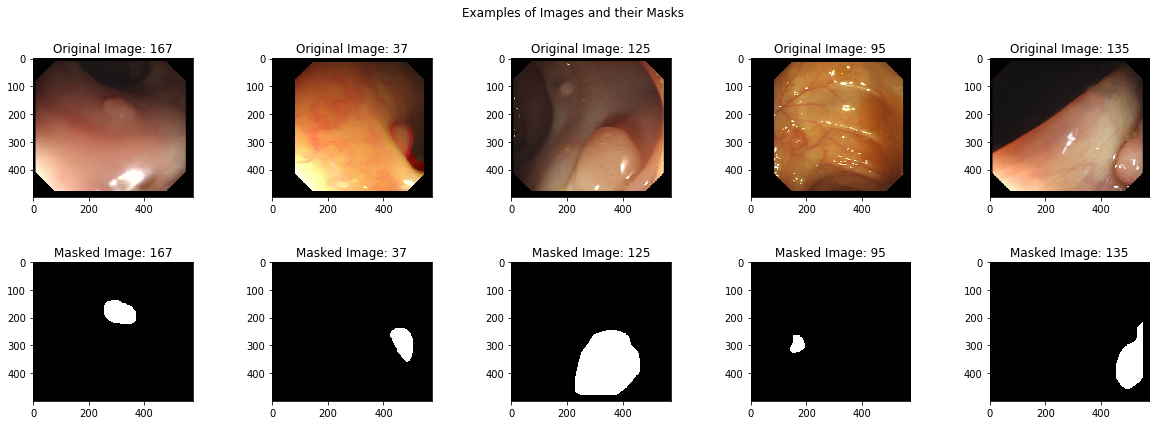

In [5]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

display_num = 5

r_choices = np.random.choice(num_train_examples, display_num)

mpl.rcParams['axes.grid'] = False
plt.figure(figsize=(20, 20))
for i in range(0, display_num):
    img_num = r_choices[i]
    x_pathname = x_train_filenames[img_num]
    y_pathname = y_train_filenames[img_num]
    
    #plt.subplot(display_num, 2, i + 1)
    plt.subplot(2, display_num, i + 1)
    plt.imshow(mpimg.imread(x_pathname))
    plt.title("Original Image: {}".format(img_num))
    
    #plt.subplot(display_num, 2, i + 2)
    plt.subplot(2, display_num, display_num + i + 1)
    plt.imshow(mpimg.imread(y_pathname), cmap='gray')
    plt.title("Masked Image: {}".format(img_num))

plt.suptitle("Examples of Images and their Masks")
plt.subplots_adjust(bottom=0.7, top=0.95, hspace=0.3, wspace=0.5)  # These params...
plt.show()

# Configurações do modelo

Vamos setar alguns parâmetros, construir todo pipeline do treinamento, treinar e ver o que acontece. 

Começamos por padronizar e reescalar as dimensões da imagem.

### Importando módulos e métodos para definição da rede

In [6]:
import tensorflow as tf
import tensorflow_addons as tfaddons

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import models
from tensorflow.keras import backend as K

### Padronizando dimensões da imagem e parâmetros do treinamento

In [7]:
img_shape = (256, 256, 3)  # Can't do 512x512, because my images are 574x500.
batch_size = 10
epochs = 200

Devido a arquitetura da rede U-Net, o tamanho da imagem precisa ser divisível por 32, pois em cada `MaxPooling2DLayer` a resolução espacial é dividida por 2.

Maiores resoluções implicam em maior performance, pois permitem uma localização mais pecisa e menos perda de informação durante a fase de _encoding_.

O valor do `batch_size` impactará de modo inversamente proporcional o tempo de treinamento. 

# Construindo fluxo de entrada com tf.data

A ideia é construir um pipeline de dados robusto e escalável que seja adequado com o modelo. API usada: [tf.data](https://www.tensorflow.org/guide/datasets). Resumindo as possibilidades com essa API:

> _For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training._

### O pipeline de entrada tem o seguintes passos:

1. Ler bytes das imagens originals e máscaras a partir do seu caminho completo (_filename_).
2. Decodificar bytes em formato de imagem.
    - _Converter de .tiff para .jpeg._
3. Aplicar transformações de imagem:
    - `resize` - Escalar as imagens para um tamanho padrão.
    - `hue_delta` - Ajusta o hue de uma imagem RGB original por um fator aleatório no intervalo `[0, 0.5]`.
    - `horizontal_flip` - Gira a imagem original e a máscara na horizontal com probabilidade de 0.5.
    - `width_shift_range`e `heigh_shift_range` são intervalos (como fração da altura ou largura total) na qual pode-se aleatoriamente transladar as imagens originais e as máscaras na vertical ou horizontal. 
    - `rescale` - Reescala a imagem por um fator qualquer, como 1/255.
4. **Misturar, repetir (tal que possamos iterar sobre várias vezes em cada época), lotear (de _batch_) e pré-buscar (por eficiência).**

É importante notar que essas transformações que ocorrem no pipeline dos dados precisam ser transformações **simbólicas**.


#### Motivação para as transformações de imagem

O nome técnico é **augmentação de imagens**. Esse procedimento "aumenta" o total do conjunto de treinamento via um número de transformações aleatórias. Durante o tempo de treinamento, o modelo nunca veria duas vezes a mesma imagem. Isso previne _overfitting_ e ajuda o modelo a generalizar melhor a dados inéditos.

## Processo cada caminho de imagem

In [8]:
# TODO: is this method functioning properly? 

def _process_pathnames(fname, label_path):
    # We map this function onto each pathname pair
    img_str = tf.io.read_file(fname)
    # ATTENTION: images have .tiff extension, not .jpeg
    img = tf.image.decode_jpeg(img_str, channels=3)

    label_img_str = tf.io.read_file(label_path)
    # My update: decode_gif to decode_jpg (BUT IMAGES ARE .tiff)
    label_img = tf.image.decode_jpeg(label_img_str)
    # The label image should only have values of 1 or 0, indicating pixel wise
    # object (car) or not (background). We take the first channel only.
    label_img = label_img[:, :, 0]
    label_img = tf.expand_dims(label_img, axis=-1)

    return img, label_img

## Desloco cada imagem

In [9]:
def shift_img(output_img, label_img, width_shift_range, height_shift_range):
    """This fn will perform the horizontal or vertical shift."""
    if width_shift_range or height_shift_range:
        if width_shift_range:
            width_shift_range = tf.random.uniform([],
                                                 -width_shift_range * img_shape[1],
                                                 width_shift_range * img_shape[1])
        if height_shift_range:
            height_shift_range = tf.random.uniform([],
                                                   -height_shift_range * img_shape[0],
                                                   height_shift_range * img_shape[0])
        # Translate both
        output_img = tfaddons.image.translate(output_img,
                                              [width_shift_range, height_shift_range])
        label_img = tfaddons.image.translate(label_img,
                                             [width_shift_range, height_shift_range])
    return output_img, label_img

## Giro cada imagem aleatoriamente

In [10]:
# Flipping the image randomly
def flip_img(horizontal_flip, tr_img, label_img):
    if horizontal_flip:
        flip_prob = tf.random.uniform([], 0.0, 1.0)
        tr_img, label_img = tf.cond(tf.less(flip_prob, 0.5),
                                    lambda: (
                                        tf.image.flip_left_right(tr_img),
                                        tf.image.flip_left_right(label_img)),
                                    lambda: (
                                        tr_img,
                                        label_img))
    return tr_img, label_img

## Agregando as transformações em um método de augmentar

In [11]:
# Assembling our transformations into our augment function
def _augment(img,
             label_img,
             resize=1,
             scale=1,
             hue_delta=0,
             horizontal_flip=False,
             width_shift_range=0,
             height_shift_range=0):
    if resize is not None:
        # Resize both images
        label_img = tf.image.resize(label_img, resize)
        img = tf.image.resize(img, resize)

    if hue_delta:
        img = tf.image.random_hue(img, hue_delta)

    img, label_img = flip_img(horizontal_flip, img, label_img)
    img, label_img = shift_img(img, label_img, width_shift_range, height_shift_range)
    label_img = tf.cast(label_img, tf.float32) * scale
    img = tf.cast(img, tf.float32) * scale

    return img, label_img

In [12]:
import functools


def get_baseline_dataset(filenames,
                         labels,
                         preproc_fn=functools.partial(_augment),
                         threads=5,
                         batch_size=batch_size,
                         shuffle=True):
    num_x = len(filenames)
    # Create a dataset from the filenames and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Map our preprocessing function to every element in our dataset,
    # taking advantage of multithreading
    # REMEMBER: images are .tiff, not .jpeg; must convert! But how?!
    dataset = dataset.map(_process_pathnames, num_parallel_calls=threads)

    if preproc_fn.keywords is not None and 'resize' not in preproc_fn.keywords:
        assert batch_size == 1, "Batching imags must be of the same size"

    dataset = dataset.map(preproc_fn, num_parallel_calls=threads)

    if shuffle:
        dataset = dataset.shuffle(num_x)

    # It's necessary to repeat our data for all epochs
    dataset = dataset.repeat().batch(batch_size)
    return dataset

## Setando datasets de treinamento e validação

Note que aplicamos augmentação de image para nosso conjunto de dados de treino, mas não de validação.

In [13]:
tr_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
    'hue_delta': 0.1,
    'horizontal_flip': True,
    'width_shift_range': 0.1,
    'height_shift_range': 0.1
}
tr_preprocessing_fn = functools.partial(_augment, **tr_cfg)

In [14]:
val_cfg = {
    'resize': [img_shape[0], img_shape[1]],
    'scale': 1 / 255.,
}
val_preprocessing_fn = functools.partial(_augment, **val_cfg)

### Gerando datasets de treinamento e validação

In [15]:
train_ds = get_baseline_dataset(x_train_filenames,
                                y_train_filenames,
                                preproc_fn=tr_preprocessing_fn,
                                batch_size=batch_size)
val_ds = get_baseline_dataset(x_val_filenames,
                              y_val_filenames,
                              preproc_fn=val_preprocessing_fn,
                              batch_size=batch_size)

## Avaliando se augmentação ocorreu como esperado

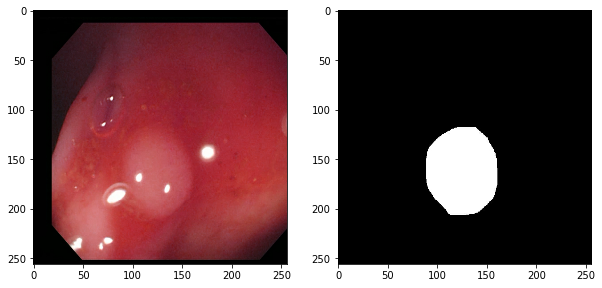

In [16]:
temp_ds = get_baseline_dataset(x_train_filenames,
                               y_train_filenames,
                               preproc_fn=tr_preprocessing_fn,
                               batch_size=1,
                               shuffle=False)
# Let's examine some of these augmented images
# data_aug_iter = temp_ds.make_one_shot_iterator()
# next_element = data_aug_iter.get_next()
data_aug_iter = iter(temp_ds)
batch_of_imgs, label = next(data_aug_iter)


# with tf.Session() as sess:
#  batch_of_imgs, label = sess.run(next_element)
#
# Running next element in our graph will produce a batch of images
plt.figure(figsize=(10, 10))
img = batch_of_imgs[0]

plt.subplot(1, 2, 1)
plt.imshow(img)

plt.subplot(1, 2, 2)
plt.imshow(label[0, :, :, 0], cmap='gray')
plt.show()

# Construção do modelo (usando a API Fucional Keras)

Aqui construímos o modelo U-Net. É um modelo bom para segmentação pois consegue localizar adequadamente as regiões de interesse. Trabalha bem com pequenos _datasets_ e é bem robusto contra _overfitting_--em relação à proporção de _patches_ para com número de imagens de treinamento.

A arquitetura é construída com uma parte **encoder** e uma parte **decoder**. 

A primeira, de codificação, é composta por uma pilha linear das seguintes operações:
  - Conv
  - BatchNorm
  - ReLU
  - MaxPool
  
Já a parte de decodificação possue:
  - UpSampling2D
  - Conv
  - BatchNorm
  - ReLU
  
**Feature maps**, ou mapa de características,  obtidos a partir de `MaxPool`s da parte de codificação, são concatenados no lado oposto. Veja a imagem da arquitetura lá no ínicio para mais clareza. Por fim, temos uma operação de convolução que executa uma convolução ao longo dos canais para cada pixel individual, que resulta a máscara final de segmentação em escala de cinza.

## API funcional Keras

Veja este [guia](https://keras.io/getting-started/functional-api-guide/). A ideia básica é construir modelos com muitas entradas e saídas, camadas compartilhadas, etc.

In [17]:
class UNet:
    def conv_block(self, input_tensor, num_filters):
        encoder = layers.Conv2D(num_filters, (3, 3),
                                padding='same')(input_tensor)
        encoder = layers.BatchNormalization()(encoder)
        encoder = layers.Activation('relu')(encoder)
        encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
        encoder = layers.BatchNormalization()(encoder)
        encoder = layers.Activation('relu')(encoder)

        return encoder

    def encoder_block(self, input_tensor, num_filters):
        encoder = self.conv_block(input_tensor, num_filters)
        encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
        return encoder_pool, encoder

    def decoder_block(self, input_tensor, concat_tensor, num_filters):
        decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2),
                                         padding='same')(input_tensor)
        decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
        decoder = layers.BatchNormalization()(decoder)
        decoder = layers.Activation('relu')(decoder)
        decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
        decoder = layers.BatchNormalization()(decoder)
        decoder = layers.Activation('relu')(decoder)
        decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
        decoder = layers.BatchNormalization()(decoder)
        decoder = layers.Activation('relu')(decoder)
        return decoder

    def build(self):
        inputs = layers.Input(shape=img_shape)  # 256)
        encoder0_pool, encoder0 = self.encoder_block(inputs, 32)
        encoder1_pool, encoder1 = self.encoder_block(encoder0_pool, 64)
        encoder2_pool, encoder2 = self.encoder_block(encoder1_pool, 128)
        encoder3_pool, encoder3 = self.encoder_block(encoder2_pool, 256)
        encoder4_pool, encoder4 = self.encoder_block(encoder3_pool, 512)  # 8
        center = self.conv_block(encoder4_pool, 1024)
        decoder4 = self.decoder_block(center, encoder4, 512)  # 16
        decoder3 = self.decoder_block(decoder4, encoder3, 256)
        decoder2 = self.decoder_block(decoder3, encoder2, 128)
        decoder1 = self.decoder_block(decoder2, encoder1, 64)
        decoder0 = self.decoder_block(decoder1, encoder0, 32)  # 256
        outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)
        return inputs, outputs

In [59]:
tf.keras.backend.clear_session()

unet = UNet()
inputs, outputs = unet.build()

## Definindo modelo

Usando a API funcional Keras precisamos definir o modelo por especificar as entradas e saídas associadas com o modelo.

In [60]:
# Defining model
model = models.Model(inputs=[inputs], outputs=[outputs])

# Definindo métricas personalizadas e funções de custo

A ideia é definir uma função que pega os **rótulos preditos** e os **rótulos verdadeiros** para o mesmo exemplo.

Uma métrica como é a *dice loss*, que mede sobreposição. Mais informações no [artigo](http://campar.in.tum.de/pub/milletari2016Vnet/milletari2016Vnet.pdf) original.

O uso dessa função aqui é justificado pelo fato dela ter uma melhor performance em problemas com desbalançeamento de classes (muitos casos negativos e poucos positivos). Além disso, maximizar o coeficiente _dice_ e métricas _IoU_ (Intersection over Union) são os atuais objetivos e metas de nossa tarefa de segmentação. Usar cross-entropia é mais um _proxy_ que é fácil de maximizar. Em vez disso, maximizamos nosso objetivo diretamente.

In [61]:
# Defining custom metrics and loss functions
def dice_coeff(y_true, y_pred):
    smooth = 1.
    # Flatten
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    score = (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)
    return score


def dice_loss(y_true, y_pred):
    loss = 1 - dice_coeff(y_true, y_pred)
    return loss


# Especialized funcion that combines binary cross entropy and our dice loss
# It would be nice try out new custom losses like bce + log(dice_loss), etc.
def bce_dice_loss(y_true, y_pred):
    loss = losses.binary_crossentropy(y_true, y_pred) + dice_loss(y_true,
                                                                  y_pred)
    return loss

## Compilando modelo

Nós usamos nossa função de custo personalizada para minimizá-la. E especificamos quais métricas queremos rastrear enquanto treinamos. Mantenha em mente que tais méticas são usadas para medir a performance do processo de treinamento.

In [62]:
model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])

In [63]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Treinando & visualizando o treinamento do modelo

Treinar o modelo com `tf.data` envolve prover o método `fit`com o _dataset_ de treinamento e validação, número de passos e épocas.

`ModelCheckpoint` é um _callback_ que irá salvar o modelo no disco em cada época. Nesse caso, foi configurado pra salvar apenas quando for o melhor modelo.



In [64]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [24]:
# save_model_path is proj_root
root = dirs['other'][0]
save_model_path = root + 'weights.hdf5'

In [25]:
root_logdir = os.path.join(os.curdir, "logs")


def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

In [65]:
run_logdir = get_run_logdir()
cb_tb = tf.keras.callbacks.TensorBoard(run_logdir, histogram_freq=1)
cb_mc = tf.keras.callbacks.ModelCheckpoint(filepath=save_model_path,
                                           monitor='val_dice_loss',
                                           save_best_only=True,
                                           verbose=1)
# Stop training when val_dice_loss has stopped improving
cb_es = tf.keras.callbacks.EarlyStopping(monitor='val_dice_loss',
                                         min_delta=0.01, patience=10,
                                         verbose=0, mode='min',
                                         baseline=None)

In [66]:
# With callbacks
history = model.fit(train_ds,
                    steps_per_epoch=int(
                        np.ceil(num_train_examples / float(batch_size))),
                    epochs=epochs,
                    validation_data=val_ds,
                    validation_steps=int(
                        np.ceil(num_val_examples / float(batch_size))),
                    callbacks=[cb_es, cb_mc, cb_tb])  # callback here

Train for 24 steps, validate for 6 steps
Epoch 1/200
23/24 [===========================>..] - ETA: 0s - loss: 1.2903 - dice_loss: 0.8889
Epoch 00001: val_dice_loss improved from inf to 0.90890, saving model to polyp_segmentation/weights.hdf5
24/24 [==============================] - 27s 1s/step - loss: 1.2857 - dice_loss: 0.8895 - val_loss: 1.4952 - val_dice_loss: 0.9089
Epoch 2/200
23/24 [===========================>..] - ETA: 0s - loss: 1.1337 - dice_loss: 0.8877
Epoch 00002: val_dice_loss did not improve from 0.90890
24/24 [==============================] - 18s 758ms/step - loss: 1.1324 - dice_loss: 0.8869 - val_loss: 1.7330 - val_dice_loss: 0.9140
Epoch 3/200
23/24 [===========================>..] - ETA: 0s - loss: 1.1014 - dice_loss: 0.8794
Epoch 00003: val_dice_loss did not improve from 0.90890
24/24 [==============================] - 19s 780ms/step - loss: 1.0997 - dice_loss: 0.8781 - val_loss: 1.5346 - val_dice_loss: 0.9089
Epoch 4/200
23/24 [===========================>..] - ET

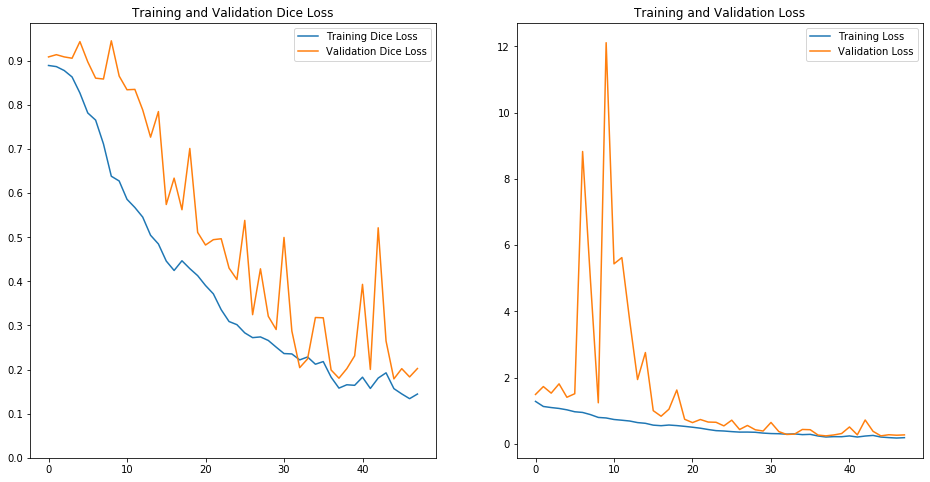

In [67]:
imgs_folder = 'raw'


if not os.path.exists('metrics'):
    os.mkdir('metrics')

dice = history.history['dice_loss']
val_dice = history.history['val_dice_loss']
np.save('metrics/dice_{}_{}_{}'.format(batch_size, epochs, imgs_folder),
        np.array(dice))
np.save('metrics/val_dice_{}_{}_{}'.format(batch_size, epochs, imgs_folder),
        np.array(val_dice))

loss = history.history['loss']
val_loss = history.history['val_loss']
np.save('metrics/loss_{}_{}_{}'.format(batch_size, epochs, imgs_folder),
        np.array(loss))
np.save('metrics/val_loss_{}_{}_{}'.format(batch_size, epochs, imgs_folder),
        np.array(val_dice))

epochs_range = range(len(dice))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, dice, label='Training Dice Loss')
plt.plot(epochs_range, val_dice, label='Validation Dice Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Dice Loss')
plt.yticks(np.arange(0, 1, 0.1))

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

# Visualizando performance atual

Idealmente, a performance deveria ser avaliada num conjunto de teste com toda resolução da imagem.



In [68]:
model = models.load_model(save_model_path, 
                          custom_objects={'bce_dice_loss': bce_dice_loss,
                                          'dice_loss': dice_loss})

# load_weights(save_model_path) would get the model directly from memory.

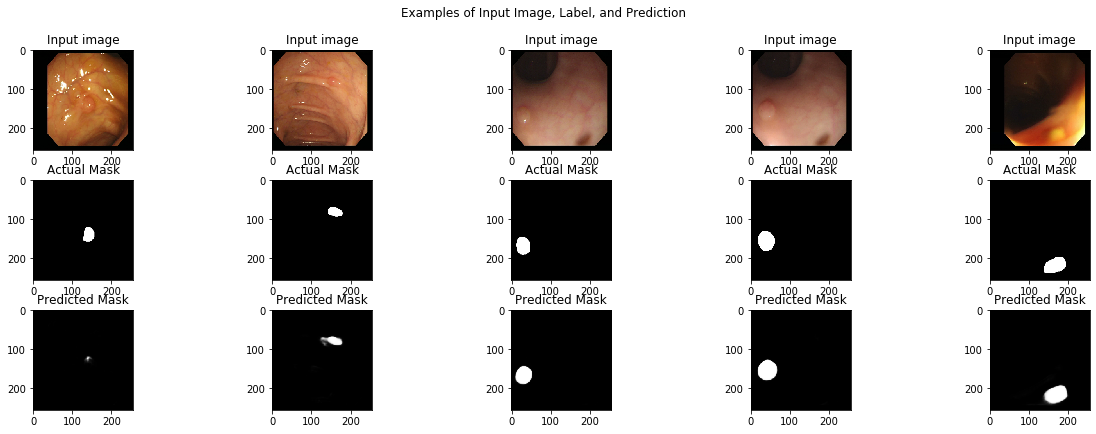

In [70]:
# Let's visualize some of the outputs
data_aug_iter = iter(val_ds)

plt.figure(figsize=(20, 20))

# Running next element in our graph will produce a batch of images
for i in range(5):
    batch_of_imgs, label = next(data_aug_iter)
    img = batch_of_imgs[0]
    predicted_label = model.predict(batch_of_imgs)[0]
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title("Input image")
    plt.subplot(3, 5, 5 + i + 1)
    plt.imshow(label[0, :, :, 0], cmap='gray')
    plt.title("Actual Mask")
    plt.subplot(3, 5, 2 * 5 + i + 1)
    plt.imshow(predicted_label[:, :, 0], cmap='gray')
    plt.title("Predicted Mask")

plt.suptitle("Examples of Input Image, Label, and Prediction")
plt.subplots_adjust(bottom=0.7, top=0.95, hspace=0.3, wspace=0.5)
plt.show()